In [1]:
import pandas as pd
import numpy as np


# time

import time
from datetime import datetime
from datetime import date

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer


# Boosting classifiers
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Save model
import pickle
import joblib

In [2]:
# fileLocation = 'C:\\Users\\VictorY\\Desktop\\TestData\\stage3FinalProcessedDF_Nov-17-2019.csv'
# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Final_Data_Movies_Directors.csv'
# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Movies_director_data_3709_119Features.csv'

# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\1_Data_Movies.csv'
moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\2_Movies_WithAwards.csv'

saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

movies_data = pd.read_csv(moviesDataFileLocation)

In [3]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3709 entries, 0 to 3708
Columns: 142 entries, director_ids to Winner_Directing (Dramatic Picture)
dtypes: float64(27), int64(107), object(8)
memory usage: 4.0+ MB


# Notebook Run Settings

chosen_feature_predicting : rating_count , rating_value , review_count_critic , review_count_user , metascore
<br>chosen_bin_method : quartiles , bin_cut , Bin_AsPaper
<br>chosen_success_class : movie_rating , director_rating
<br>chosen_dataset_balance : unbalanced , balanced
<br>chosen_scaling_method : MinMaxScaler , None

In [4]:
gender_as_an_input = 'Yes'
chosen_feature_predicting = 'rating_count'
chosen_bin_method = 'quartiles'
chosen_success_class = 'movie_class'
chosen_dataset_ratio = 'balanced'
chosen_scaling_method = 'None'
default_learning_rate = 0.1
chosen_max_leaf_nodes = 32
default_max_depth = 3
chosen_max_features = None
chosen_random_state = 42

In [5]:
Q = [0,0.25,0.5,0.75,1]
for num , q in enumerate(Q):
    print("Quantile {0}% : {1} ".format(num * 25 , movies_data[chosen_feature_predicting].quantile(q)))

Quantile 0% : 29.0 
Quantile 25% : 13489.0 
Quantile 50% : 46445.0 
Quantile 75% : 124812.0 
Quantile 100% : 1718048.0 


## Movie classes

In [6]:
def undersampling_balanced_gender(df,balance_feature = 'Gender', column_tobe_unique = 'director_ids'):
    
    # Shuffle the Dataset.
    shuffled_data = df.sample(frac=1,random_state=42)
    print('Unbalanced dataframe shape after undersampling :',shuffled_data.shape)

    # First remove all duplicates director_ids to have only unique columns
    unique_column_df = shuffled_data.drop_duplicates(subset = column_tobe_unique, keep='first', inplace=False)
    unique_column_df.shape
    
    # An empty balanced data frame with only the unique columns
    bal_total_unique_list_df = pd.DataFrame()
    
    # Add balanced values from all the possible classes    
    for i in unique_column_df[balance_feature].value_counts().index:
        bal_total_unique_list_df = bal_total_unique_list_df.append(unique_column_df[(unique_column_df[balance_feature]==i)]
                                                   .sample(
                                                       n= unique_column_df[balance_feature].value_counts().values.min(),
                                                       random_state = 42,
                                                       replace = False)
                                                  )
    # list of unique IDs
    total_list_unique_IDs = bal_total_unique_list_df[column_tobe_unique].to_list()
    
    balanced_data = shuffled_data[shuffled_data[column_tobe_unique].isin(total_list_unique_IDs)] 
    
    print('Balanced dataframe shape after undersampling :',balanced_data.shape)
    return balanced_data

In [7]:
def balance_gender(dataframe):
    female_list_unique_directors = dataframe[(dataframe['Gender'] == 'Female')].director_ids.unique().tolist()
    
    unique_male_directors = dataframe[(dataframe['Gender'] == 'Male')].director_ids.unique().tolist()
    
    male_list_unique_directors = np.random.choice(unique_male_directors, replace = False, size = len(female_list_unique_directors)).tolist()
    
    total_list_unique_directors = female_list_unique_directors + male_list_unique_directors

    dataframe = dataframe[dataframe['director_ids'].isin(np.array(total_list_unique_directors).tolist())]

    return dataframe

In [8]:
# Generic function to equally max split the dataframe with respect to the column Name, in our case the Gender column.

def max_equal_split_on_columnName(df,columnName= chosen_success_class):
    df1 = pd.DataFrame()
    for i in df[columnName].value_counts().index:
        df1 = df1.append(df[(df[columnName]==i)]
                         .sample(n=df[columnName]
                                 .value_counts()
                                 .values.min()
                                 ,replace = False)
                        )        
    return df1.reset_index(drop=True)

In [9]:
# def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
#     lb = LabelBinarizer()
#     lb.fit(y_test)
#     y_test = lb.transform(y_test)
#     y_pred = lb.transform(y_pred)
#     return roc_auc_score(y_test, y_pred, average=average)

In [10]:
def print_feature_importances(coef, names, top=-1):
    whole = []
    imp = coef
    imp,names = zip(*sorted(list(zip(imp, names)),reverse=True))
    for i in range(len(names)):
        string = "{} :: {}".format(str(names[i]),str(round(imp[i],3)))
        whole.append(string)
    return whole

# Functions : Bin Cuts , Quartile Bins and bins as in paper

## Bin Cuts

In [11]:
def bincuts(df,class_feature = 'rating_value'):
    
    # Bin cuts into 4 buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.cut(df[class_feature].to_list(), bins = 4 ,labels=bin_quartiles)

    # Print the quartile range for visuals
    print(cutIntoQuartiles.categories)

    # Add the data to the dataframe
    df[chosen_success_class] = cutIntoQuartiles
    df[chosen_success_class] = df[chosen_success_class].astype(object)
    print('The shape of our Movies dataset is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our Movies dataset is:', df.shape)

## Quartile Bins

In [12]:
def quartile_bin(df,class_feature='rating_value'):
    # Quartile cut into 4 different buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.qcut(df[class_feature].to_list(), q=4,labels=bin_quartiles)
    
    print(cutIntoQuartiles.categories)
    
    df[chosen_success_class] = cutIntoQuartiles
    df[chosen_success_class] = df[chosen_success_class].astype(object)
    print('The shape of our dataset before dropping the class feature is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our dataset after dropping the class feature  is:', df.shape)
    return df

## Paper Implementation of bins

In [13]:
def success_measure(score):
    
    if score > 0 and score <= 2.4:
        return 'poor'
#     elif score > 2.4 and score <= 5.0:a
        return 'average'
    elif score > 5.0 and score <= 7.4:
        return 'good'
    elif score > 7.4 and score <=10.0:
        return 'excellent'
    else:
        return 'Error_Score'

# Function - To choose which Success measure to choose and what binning technique

In [14]:
def choose_success_measure(df, bin_method = 'Quartiles', feature = 'rating_value'):
    
    # Stats of the feature
    print('\nDescribing the feature : \n')
    print(df[feature].describe())
    

    
    if (bin_method == 'quartiles'):
        # Quartie bin cuts
        df = quartile_bin(df,feature)
            
    elif(bin_method == 'bin_cut'):
        # Bin cuts
        df = bincuts(df,'rating_value')
        
    elif(bin_method == 'Bin_AsPaper'):
        df[chosen_success_class] = df[feature].apply(success_measure).astype('category')
        
        print('\nShape of the dataset : \n')
        print('\nThe shape of our Movies dataset is:', df.shape)
        df.drop(columns = [feature] , inplace = True)
        print('\nThe shape of our Movies dataset is:', df.shape)
    
    print('\nValue Count of the bucketed class is : \n')
    print(df[chosen_success_class].value_counts())

# Weighted Rank

In [15]:
# Weighted ranking value
# IMDB uses this famous formula:
# weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

# Where:

# R = average for the movie (mean) = (rating)

# v = number of votes for the movie = (votes)

# m = minimum votes required to be listed in the Top Rated list (currently 25,000)

# C = the mean vote across the whole report

In [16]:
def weightedRank(df,R='rating_value', v='rating_count', m = 100):
#     df = df.loc[df[v] > m ]
    df['weighted_rank'] = (df[v] / (df[v] + m )) * df[R] + (m / ( df[v] + m)) * df[R].mean()
    return df

In [17]:
minVotes =  movies_data.rating_count.quantile(0.5)
minVotes

46445.0

### Bin Cuts

In [18]:
# # Quartie bin on Weighted rating value
# movies_data = bincuts(movies_data,'weighted_rank')

### Quartile Bins

In [19]:
# movies_data.rating_count.describe()

In [20]:
# movies_data = weightedRank( movies_data, m = minVotes )

# # Quartie bin on Weighted rating value

# movies_data.drop(columns = 'rating_value',inplace = True)
# movies_data = quartile_bin(movies_data,'weighted_rank')

### Paper Implementation of bins

In [21]:
# movies_data['movie_class'] = movies_data['weighted_rank'].apply(success_measure).astype('category')
# print('The shape of our Movies dataset is:', movies_data.shape)# print('The shape of our Movies dataset is:', movies_data.shape)
# movies_data.drop(columns = ['weighted_rank'] , inplace = True)
# print('The shape of our Movies dataset is:', movies_data.shape)

## Run the feature based on the bin cut and success feature

In [22]:
chosen_feature_predicting

'rating_count'

In [23]:
cutIntoQuartiles = pd.qcut(movies_data[chosen_feature_predicting].to_list(), q=4)
print("Quantiles bin range")
for i,num in enumerate(cutIntoQuartiles.categories):
    print("Quantile {0} : {1} ".format(i,num))

Quantiles bin range
Quantile 0 : (28.999, 13489.0] 
Quantile 1 : (13489.0, 46445.0] 
Quantile 2 : (46445.0, 124812.0] 
Quantile 3 : (124812.0, 1718048.0] 


In [24]:
choose_success_measure(movies_data , bin_method = chosen_bin_method , feature = chosen_feature_predicting)


Describing the feature : 

count    3.709000e+03
mean     1.031944e+05
std      1.555293e+05
min      2.900000e+01
25%      1.348900e+04
50%      4.644500e+04
75%      1.248120e+05
max      1.718048e+06
Name: rating_count, dtype: float64
Index(['terrible', 'poor', 'average', 'excellent'], dtype='object')
The shape of our dataset before dropping the class feature is: (3709, 143)
The shape of our dataset after dropping the class feature  is: (3709, 142)

Value Count of the bucketed class is : 

terrible     928
poor         927
average      927
excellent    927
Name: movie_class, dtype: int64


In [25]:
# movies_data = movies_data[movies_data['movie_class'].isin(['poor','excellent'])]

### Remove Features from dataset which are not required

In [26]:
# # Unique director distribution in max_equal DF
# print("Unique director distribution - movies_data split based on Gender")

# movies_data.drop_duplicates(subset = 'director_ids', keep = 'first').Gender.value_counts()

In [27]:
object_features_to_remove = movies_data.select_dtypes(include = 'object').columns.values.tolist()
object_features_to_remove.remove('Gender')
object_features_to_remove.remove('movie_class')
object_features_to_remove

['director_ids',
 'director_names',
 'movie_id',
 'title',
 'release_date',
 'Film',
 'Name']

### Balanced Movies Dataset

In [28]:
# important_features = ['director_known_titles_average_rating_value',
#        'director_profession_secondary', 'director_profession_tertiary',
#        'genre_Animation', 'genre_Family', 'genre_Mystery',
#        'genre_Thriller', 'rating_count', 'review_count_user']

# important_features.remove('rating_count')
# important_features.extend(['movie_class'])

In [29]:
balanced_movies_data = undersampling_balanced_gender(movies_data)

Unbalanced dataframe shape after undersampling : (3709, 142)
Balanced dataframe shape after undersampling : (1320, 142)


In [30]:
balanced_movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1320 entries, 1929 to 1294
Columns: 142 entries, director_ids to movie_class
dtypes: float64(27), int64(106), object(9)
memory usage: 1.4+ MB


In [31]:
balanced_movies_data[chosen_success_class].value_counts()

terrible     357
poor         350
excellent    310
average      303
Name: movie_class, dtype: int64

In [32]:
print('The shape of our Balanced Movies dataset before removing object type features:', balanced_movies_data.shape)
# movies_data = movies_data[movies_data.columns.difference(object_features_to_remove)]
balanced_movies_data = balanced_movies_data.drop(columns= object_features_to_remove)
print('The shape of our Balacned Movies dataset after dropping object type features:', balanced_movies_data.shape)

The shape of our Balanced Movies dataset before removing object type features: (1320, 142)
The shape of our Balacned Movies dataset after dropping object type features: (1320, 135)


### Unbalanced Movies Dataset

In [33]:
# important_features = ['director_known_titles_average_rating_value',
#        'director_profession_secondary', 'director_profession_tertiary',
#        'genre_Animation', 'genre_Family', 'genre_Mystery',
#        'genre_Thriller', 'rating_count', 'review_count_user']

# important_features.remove('rating_count')
# important_features.extend(['movie_class'])

In [34]:
print('The shape of our Unbalanced Movies dataset before:', movies_data.shape)
# movies_data = movies_data[movies_data.columns.difference(object_features_to_remove)]
movies_data = movies_data.drop(columns= object_features_to_remove)
print('The shape of our Unbalanced Movies dataset after dropping object features:', movies_data.shape)

The shape of our Unbalanced Movies dataset before: (3709, 142)
The shape of our Unbalanced Movies dataset after dropping object features: (3709, 135)


In [35]:
movies_data[chosen_success_class].value_counts()

terrible     928
poor         927
average      927
excellent    927
Name: movie_class, dtype: int64

### Scatter plot visualize - One feature vs another with respect to movie_class

In [36]:
# visuaize_movies_data = movies_data.replace({'Gender' : { 'Male' : 1, 'Female' : 0 }})
# visuaize_movies_data.drop(columns = 'Gender',inplace = True)

visuaize_movies_data = movies_data.copy()

In [37]:
# import matplotlib.pyplot as plt
# g = sns.PairGrid(movies_data,hue='movie_class' , hue_order = ['terrible','poor','average','excellent'])
# g.map(plt.scatter)
# g.add_legend()
# g.savefig("summary_plot.png")

In [38]:
sample_movies_data = movies_data.sample(n=1000,replace = False, random_state =42)

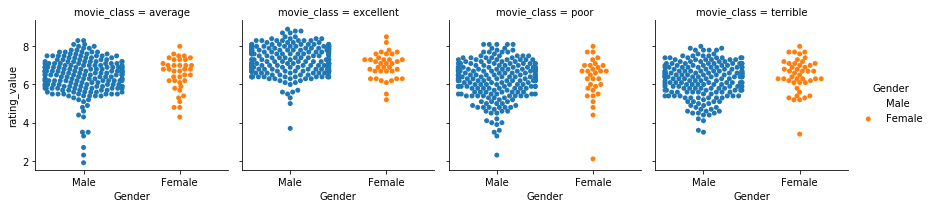

In [39]:
g = sns.FacetGrid(sample_movies_data, col='movie_class', hue='Gender')
g = g.map(sns.swarmplot, 'Gender', 'rating_value', order=["Male", "Female"], hue_order=[0, 1])
g.add_legend()

In [40]:
sample_movies_data = balanced_movies_data.sample(n=1000,replace = False, random_state =42)

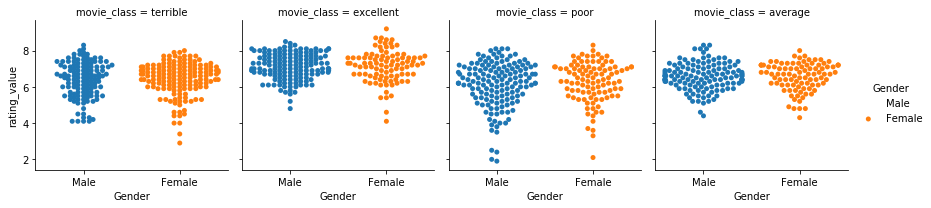

In [41]:
g = sns.FacetGrid(sample_movies_data, col='movie_class', hue='Gender')
g = g.map(sns.swarmplot, 'Gender', 'rating_value', order=["Male", "Female"], hue_order=[0, 1])
g.add_legend()

In [42]:
visuaize_movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3709 entries, 0 to 3708
Columns: 135 entries, review_count_user to movie_class
dtypes: float64(27), int64(106), object(2)
memory usage: 3.8+ MB


In [43]:
without_excellent_data = visuaize_movies_data[visuaize_movies_data['movie_class'].isin(['terrible','poor','average'])]

In [44]:
# import matplotlib.pyplot as plt
# g = sns.PairGrid(without_excellent_data,hue='movie_class')
# g.map(plt.scatter)
# g.add_legend()
# g.savefig("summary_plot.png")

### Choosing dataset for the analysis

In [45]:
chosen_dataframe = ''
if(chosen_dataset_ratio == 'unbalanced'):
    chosen_dataframe = movies_data
elif(chosen_dataset_ratio == 'balanced'):
    chosen_dataframe = balanced_movies_data

### One hot encoding for Gender

In [46]:
def one_hot_encode_gender(df,one_hot_feature = 'Gender'):
    print('Before one hot encoding , Shape ;', df.shape)
    # one hot encoding of Gender
    df = pd.concat([df, pd.get_dummies(df[one_hot_feature],prefix= one_hot_feature,dtype = int)],axis=1)
    df.drop([one_hot_feature],axis=1, inplace=True)
    print('After one hot encoding , Shape ;', df.shape)
    df.head(2)
    return df

In [47]:
chosen_dataframe = one_hot_encode_gender(chosen_dataframe)

Before one hot encoding , Shape ; (1320, 135)
After one hot encoding , Shape ; (1320, 136)


In [48]:
def reverse_one_hot_encoding(df):
    reverse_one_hot_Gender = df.loc[:, df.columns.str.startswith('Gender')].idxmax(axis = 'columns')
    df['Gender'] = reverse_one_hot_Gender

    # Replace Gender_Male with Male and Gender_Female with Female
    df['Gender'] = df['Gender'].str.replace('Gender_male','Male')
    df['Gender'] = df['Gender'].str.replace('Gender_Female','Female')
    # Drop the one hot encoded value
    df.drop(['Gender_Female','Gender_male'],axis=1, inplace=True)
    return df

## Decide if Gender is an input feature or not

In [49]:
gender_as_an_input

'Yes'

In [50]:
if(gender_as_an_input == 'Yes'):
    print("Gender is an input feature for this run! No dropping!")
    print('The shape of our Chosen dataset after dropping Gender features:', chosen_dataframe.shape)
else:
    chosen_dataframe.drop(columns = ['Gender_Male','Gender_Female'],inplace = True)
    print("Gender features removed as it is not an input feature for this run!  ")
    print('The shape of our Chosen dataset after dropping Gender features:', chosen_dataframe.shape)

Gender is an input feature for this run! No dropping!
The shape of our Chosen dataset after dropping Gender features: (1320, 136)


In [51]:
chosen_dataset_ratio

'balanced'

In [52]:
chosen_dataframe[chosen_success_class].value_counts()

terrible     357
poor         350
excellent    310
average      303
Name: movie_class, dtype: int64

# Observations

In [53]:
# Function to Plot - Distribution of rating value among male and female. 

def plot_features_WRT_gender(df,columnCriteriaName,columnFeatureName):
    dict={}
    for i in df[columnCriteriaName].value_counts().index:
        dict["{0}_{1}".format(columnFeatureName,i)] = df[(df[columnCriteriaName] == i)][columnFeatureName]
    for k,v in dict.items():
        sns.distplot(v,label=[k])
        plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

## Divide the data to training and testing - Scaling methods too

Check about the Scaling

In [54]:
def divide_test_train_with_scaling_methods(df,predict= chosen_success_class,scalingMethod = "MinMaxScaler"):
    
    
    # Feature matrix and target variable
    X = df.drop(predict,axis = 'columns')
    y = df[predict]
    
    # Scaling
    if (scalingMethod == "MinMaxScaler"):
        print("The scaling method used is : ",scalingMethod)
        scaler = MinMaxScaler()
        new_X = scaler.fit_transform(X)
        # X_test = scaler.transform(X_test)
        
    else:
        print("No Scaling Method used or incorrect input")
        new_X = X
    
    # Divide the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.20, random_state = 42 , stratify = y )
    
    return X_train, X_test, y_train, y_test

In [55]:
# Divide the data into training and test

X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(chosen_dataframe,scalingMethod= chosen_scaling_method)

No Scaling Method used or incorrect input


# Plot Confusion Matrix

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Function for Run Info :

In [57]:
def run_info(classifier):
    print('\n**Run Info - ' + classifier + '**')
    print('Dataset Shape :', chosen_dataframe.shape)
    print('Dataset ratio of classes is', chosen_dataset_ratio)
    print('Predicting feature :', chosen_feature_predicting)
    print('Bin Method :', chosen_bin_method)
    print('Scaling Method :', chosen_scaling_method)
    print('Learning Rate :',default_learning_rate)
    print('****************\n')
    return

# Boosting Classifiers

### 1.  Gradient Boosting Classifier

#### 1a) Identify the optimal Learning rate

In [58]:
# optimal_learning_rate = learningRateDF['learning_rate'].loc[learningRateDF.
#                                                                 mask((learningRateDF == learningRateDF.min())
#                                                                      .cumsum()
#                                                                      .astype(bool))
#                                                                 [::-1]
#                                                                 .idxmax()
#                                                                 ['testing_accuracy']]

In [59]:
def optimal_learning_rate(X_train, X_test, y_train, y_test):
    
    lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

    col_learningDF = ['learning_rate','training_accuracy','testing_accuracy']
    learningRateDF = pd.DataFrame(columns=col_learningDF)

    for learning_rate in lr_list:

        gb_clf = GradientBoostingClassifier(n_estimators=100,
                                            learning_rate=learning_rate,
#                                             max_leaf_nodes= 32,
#                                             max_features=2,
#                                             max_depth=2,
                                            random_state= 42 )
        gb_clf.fit(X_train, y_train)

        accuracy_train_score = gb_clf.score(X_train, y_train)
        accuracy_test_score = gb_clf.score(X_test, y_test)

        learningRateDF.loc[len(learningRateDF)] = [learning_rate,accuracy_train_score,accuracy_test_score]
#         print("Learning rate: ", learning_rate)
#         print("Accuracy score (training): {0:.3f}".format(accuracy_train_score))
#         print("Accuracy score (test): {0:.3f}".format(accuracy_test_score))
    print(learningRateDF)

    optimal_learning_rate = learningRateDF['learning_rate'].loc[learningRateDF.testing_accuracy.argmax()]

# # Script to find the maximum learning_rate where the test_accuracy is maximum

#     optimal_learning_rate = learningRateDF['learning_rate'].loc[((learningRateDF == learningRateDF.min())
#                                                                  .cumsum()
#                                                                  .astype(bool))
#                                                                 [::-1].idxmax()
#                                                                 ['testing_accuracy']
#                                                                ]

    return optimal_learning_rate

In [60]:
# chosen_learning_rate_GB = optimal_learning_rate(X_train, X_test, y_train, y_test)
chosen_learning_rate_GB = default_learning_rate
print("\nThe optimal learning rate for XGB Classifier is :",chosen_learning_rate_GB)


The optimal learning rate for XGB Classifier is : 0.1


#### 1b) Model Function

In [61]:
def train_model_Gradient_Boosting_classifier(X_train, X_test, y_train, y_test,learning_rate = 1):
    
    start = time.time()
    print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))
    
    labelMovieClass = ['terrible','poor','average','excellent']

    # Classifier parameters    
    gb_clf = GradientBoostingClassifier(n_estimators=100,
                                         learning_rate= default_learning_rate,
                                         max_leaf_nodes= chosen_max_leaf_nodes,
                                         max_features= chosen_max_features,
                                         max_depth= default_max_depth,
                                         random_state= chosen_random_state
                                        )
    
    gb_clf.fit(X_train, y_train)
    
    # Predict classes
    y_pred = gb_clf.predict(X_test)
    y_prob = gb_clf.predict_proba(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelMovieClass )
#     np.set_printoptions(precision=2)
    
    classifier_name = gb_clf.__class__.__name__
    train_size = int(round((len(X_train) / len(chosen_dataframe)),1) * 100)
    test_size = int(round((len(X_test) / len(chosen_dataframe)),1) * 100)
    
    # Print run info
    run_info(classifier_name)
    
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelMovieClass,
                      title='Confusion matrix, without normalization')
    
    
    gb_train_score = gb_clf.score(X_train, y_train)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(gb_train_score,3),train_size))
    
    gb_test_score = gb_clf.score(X_test, y_test)
    print("Testing Score of {0} on {2} % data : {1} ".format(classifier_name,round(gb_test_score,3),test_size))
    
    # Performance metrics
    
    macro_ovo_roc_auc = roc_auc_score(y_test, y_prob,average= "macro" , multi_class = 'ovo')
    print( "\nArea Under the Curve - ROC (OVO , Macro) : ",round(macro_ovo_roc_auc,3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))

#     print("\nConfusion Matrix:\n")
#     print(cnf_matrix)

    print("\nClassification Report\n")
#     print(classification_report(y_test, y_pred))
    print(classification_report(y_test, y_pred, labels = labelMovieClass ))
    
    # Stop timer
    end = time.time()
    print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
    total_time = str(round((end - start)/60,2))
    print("Total time taken in minutes: " + str((end - start)/60))
      
    return gb_clf

#### 1c) Run Results of Gradient Boosting Model

Started Reading files at :2020-04-27 20:56:02

**Run Info - GradientBoostingClassifier**
Dataset Shape : (1320, 136)
Dataset ratio of classes is balanced
Predicting feature : rating_count
Bin Method : quartiles
Scaling Method : None
Learning Rate : 0.1
****************

Confusion matrix, without normalization
[[60 11  0  0]
 [10 52  8  0]
 [ 0 16 36  9]
 [ 0  0  9 53]]

Training Score of GradientBoostingClassifier on 80 % data : 0.982 
Testing Score of GradientBoostingClassifier on 20 % data : 0.761 

Area Under the Curve - ROC (OVO , Macro) :  0.925
Matthews_corrcoef :  0.682

Classification Report

              precision    recall  f1-score   support

    terrible       0.86      0.85      0.85        71
        poor       0.66      0.74      0.70        70
     average       0.68      0.59      0.63        61
   excellent       0.85      0.85      0.85        62

    accuracy                           0.76       264
   macro avg       0.76      0.76      0.76       264
weighted avg

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=32,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

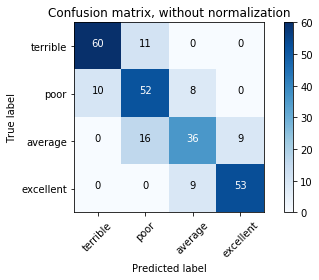

In [62]:
train_model_Gradient_Boosting_classifier(X_train, X_test, y_train, y_test,learning_rate = chosen_learning_rate_GB)
# tn, fp, fn, tp

### 2. XGB Classifier

#### 2b) Optimal learning rate

In [63]:
def optimal_learning_rate_xgb(X_train, X_test, y_train, y_test):
    
    lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

    col_learningDF = ['learning_rate','training_accuracy','testing_accuracy']
    learningRateDF = pd.DataFrame(columns=col_learningDF)

    for learning_rate in lr_list:

        xgb_clf = XGBClassifier(n_estimators=100,
                                learning_rate=learning_rate,
                                 max_leaf_nodes= chosen_max_leaf_nodes,
                                 max_features= chosen_max_features,
                                 max_depth= default_max_depth,
                                 random_state= chosen_random_state
                               )
        
        xgb_clf.fit(X_train, y_train)

        accuracy_train_score = xgb_clf.score(X_train, y_train)
        accuracy_test_score = xgb_clf.score(X_test, y_test)

        learningRateDF.loc[len(learningRateDF)] = [learning_rate,accuracy_train_score,accuracy_test_score]
#         print("Learning rate: ", learning_rate)
#         print("Accuracy score (training): {0:.3f}".format(accuracy_train_score))
#         print("Accuracy score (test): {0:.3f}".format(accuracy_test_score))
    print(learningRateDF)

    optimal_learning_rate = learningRateDF['learning_rate'].loc[learningRateDF.testing_accuracy.argmax()]

# # Script to find the maximum learning_rate where the test_accuracy is maximum

#     optimal_learning_rate = learningRateDF['learning_rate'].loc[((learningRateDF == learningRateDF.min())
#                                                                  .cumsum()
#                                                                  .astype(bool))
#                                                                 [::-1].idxmax()
#                                                                 ['testing_accuracy']
#                                                                ]

    return optimal_learning_rate

In [64]:
# chosen_learning_rate_XGB = optimal_learning_rate_xgb(X_train, X_test, y_train, y_test)
chosen_learning_rate_XGB = default_learning_rate
print("\nThe optimal learning rate for XGB Classifier is :",chosen_learning_rate_XGB)


The optimal learning rate for XGB Classifier is : 0.1


#### 2b) Model Function

In [65]:
gb_clf = GradientBoostingClassifier(n_estimators=100,
                                    learning_rate= 0.1,
                                    max_leaf_nodes= 32,
                                    max_features= None,
                                    max_depth= 3,
                                    random_state= 42
                                   )

In [66]:
xgb_clf = XGBClassifier(n_estimators=100,
                        learning_rate= 0.1,
                        max_leaf_nodes= 32,
                        max_features= None,
                        max_depth= 3,
                        random_state= 42
                       )

In [67]:
def train_model_XGB_classifier(X_train, X_test, y_train, y_test,learning_rate = 1):
    
    start = time.time()
    print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))
    
    labelMovieClass = ['terrible','poor','average','excellent']
    
    # Classifier parameters    

    xgb_clf = XGBClassifier(n_estimators=100,
                            learning_rate=learning_rate,
                            max_leaf_nodes= chosen_max_leaf_nodes,
                            max_features= chosen_max_features,
                            max_depth= default_max_depth,
                            random_state= chosen_random_state
                           )
    
    xgb_clf.fit(X_train, y_train)
    
    # Predict classes
    y_pred = xgb_clf.predict(X_test)
    y_prob = xgb_clf.predict_proba(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelMovieClass )
    np.set_printoptions(precision=2)
    
    classifier_name = xgb_clf.__class__.__name__
    train_size = int(round((len(X_train) / len(chosen_dataframe)),1) * 100)
    test_size = int(round((len(X_test) / len(chosen_dataframe)),1) * 100)
    
    # Print run info
    run_info(classifier_name)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelMovieClass,
                      title='Confusion matrix, without normalization')
    
    xgb_train_score = xgb_clf.score(X_train, y_train)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(xgb_train_score,3),train_size))
    
    xgb_test_score = xgb_clf.score(X_test, y_test)
    print("\nTraining Score of {0} on {2} % data : {1} ".format(classifier_name,round(xgb_test_score,3),test_size))
    
        
    # Performance metrics
    macro_ovo_roc_auc = roc_auc_score(y_test, y_prob,average= "macro" , multi_class = 'ovo')
    print( "\nArea Under the Curve - ROC (OVO , Macro) : ",round(macro_ovo_roc_auc,3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))

    print("\nClassification Report\n")
    print(classification_report(y_test, y_pred, labels = labelMovieClass ))
    
    # Stop timer
    end = time.time()
    print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
    total_time = str(round((end - start)/60,2))
    print("Total time taken in minutes: " + str((end - start)/60))
  
    return xgb_clf

###  2c) Run results of XGB Model

Started Reading files at :2020-04-27 20:56:04

**Run Info - XGBClassifier**
Dataset Shape : (1320, 136)
Dataset ratio of classes is balanced
Predicting feature : rating_count
Bin Method : quartiles
Scaling Method : None
Learning Rate : 0.1
****************

Confusion matrix, without normalization
[[61 10  0  0]
 [ 7 55  8  0]
 [ 0 16 36  9]
 [ 0  0 11 51]]

Training Score of XGBClassifier on 80 % data : 0.94 

Training Score of XGBClassifier on 20 % data : 0.769 

Area Under the Curve - ROC (OVO , Macro) :  0.922
Matthews_corrcoef :  0.692

Classification Report

              precision    recall  f1-score   support

    terrible       0.90      0.86      0.88        71
        poor       0.68      0.79      0.73        70
     average       0.65      0.59      0.62        61
   excellent       0.85      0.82      0.84        62

    accuracy                           0.77       264
   macro avg       0.77      0.76      0.77       264
weighted avg       0.77      0.77      0.77       

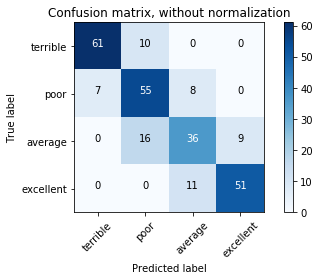

In [68]:
xgb_clf = train_model_XGB_classifier(X_train, X_test, y_train, y_test,learning_rate = chosen_learning_rate_XGB)
# tn, fp, fn, tp

In [69]:
break

SyntaxError: 'break' outside loop (<ipython-input-69-6aaf1f276005>, line 4)

## Feature Importance

In [ ]:
X_test.columns.values

In [ ]:
feature_imp_xgb = xgb_clf.feature_importances_

In [ ]:
feature_imp_xgb

In [ ]:
feature_imp_xgb[feature_imp_xgb>0.05]

In [ ]:
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [ ]:
from xgboost import plot_importance

In [ ]:
# plot feature importance
plot_importance(xgb_clf)

## Feature selection of XGB

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# select features using threshold
selection = SelectFromModel(estimator = xgb_clf, threshold='median', prefit=True)
select_X_train = selection.transform(X_train)

In [ ]:
# train model
selection_model = XGBClassifier(n_estimators = 100,
                                learning_rate = 0.1,
                                max_leaf_nodes = 32,
                                max_features = 2,
                                max_depth = 2,
                                random_state = 42
                                )

selection_model.fit(select_X_train, y_train)

In [ ]:
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

In [ ]:
labelMovieClass = ['poor','average','good','excellent']
print("Classification Report")
print(classification_report(y_test, y_pred, labels = labelMovieClass ))

In [ ]:
# Feature importance based on contribution to the classifier model
print("\nAbsolute contributions\n")
absoluteListOrder = print_feature_importances(abs(trainedSVClassifier.coef_[0]), featuresSelected)
for j in absoluteListOrder:
    print(j)

In [ ]:
print("\nPositive and Negative contributions\n")
listOrder = print_feature_importances((trainedSVClassifier.coef_[0]), featuresSelected)
for i in listOrder:
    print(i)

# End